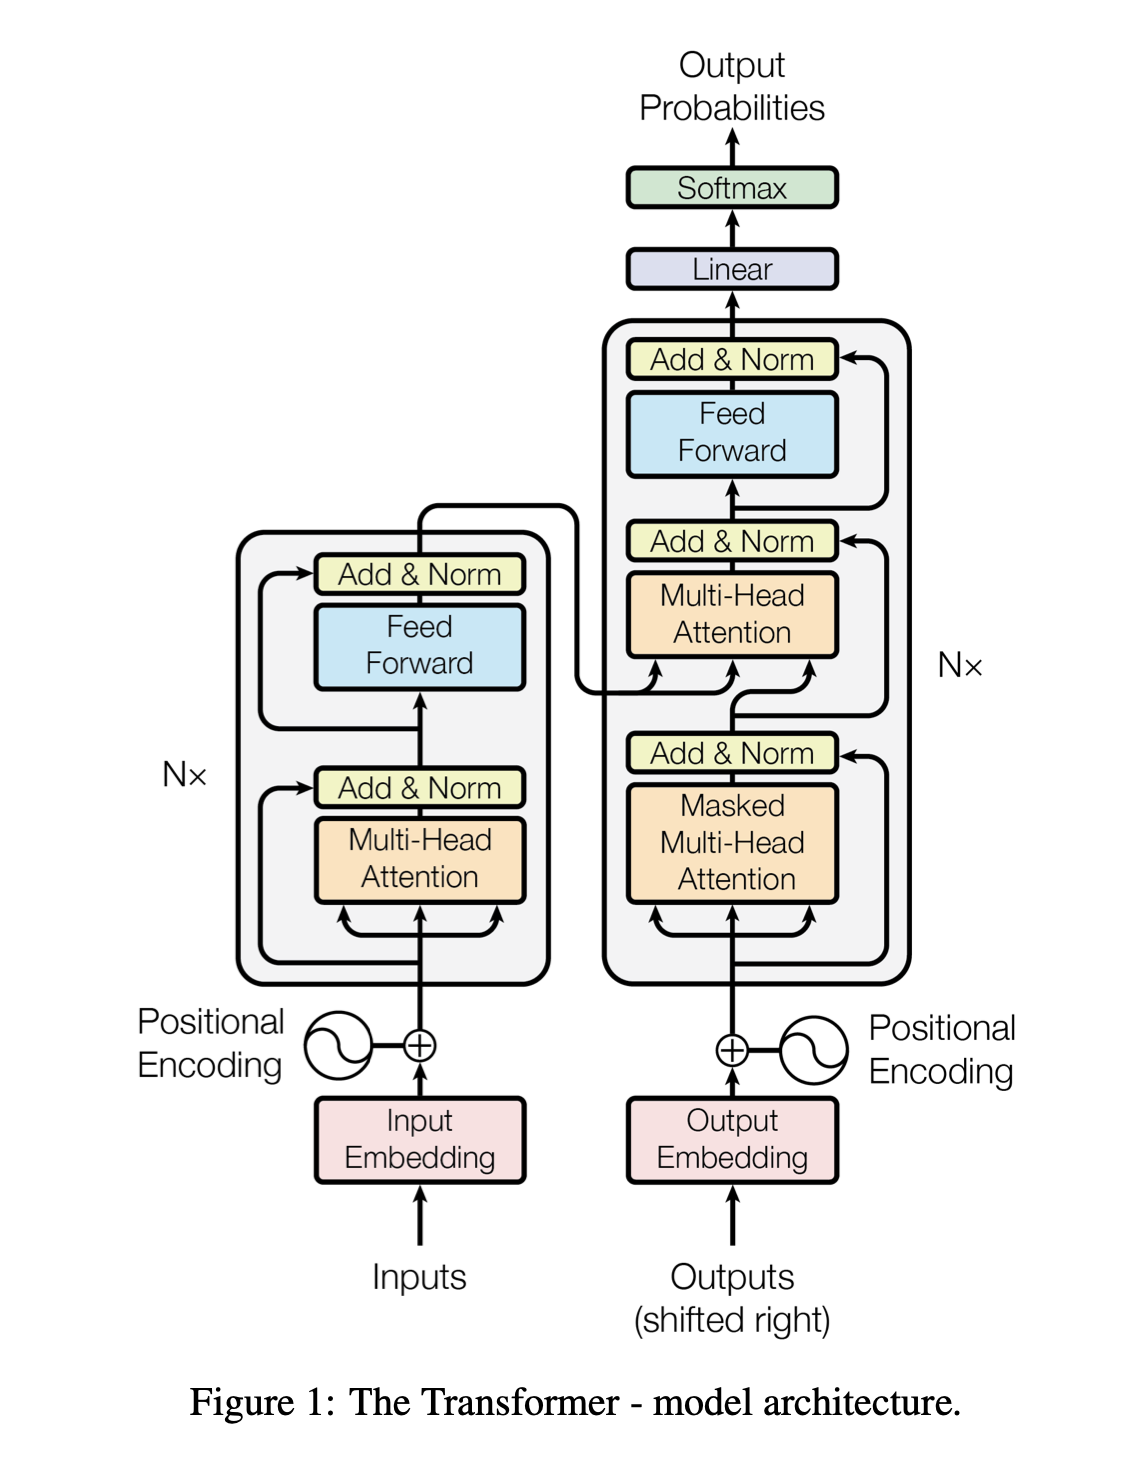

## Objective:
1. Make a transformer encoder (3 layer)
2. Make a transformer decoder (3 layer)
3. Test on text data

In [39]:
import torch
from torch import nn
from torch import tensor
import torch.nn.functional as F
import numpy as np

In [365]:
def shape_data(X:tensor, batch_size:int, seq_length:int, model_dim:int) -> tensor:
    # Creates a 3-D maxtrix of shape (batch_size, seq_length, model_dim)
    
    overall_size = batch_size*seq_length*model_dim
    if len(X.flatten()) < overall_size:
        X = X.flatten()
        print(f'Padding input with {overall_size-len(X)} 0s...')
        X = torch.concatenate([X, torch.zeros(overall_size-len(X))])

    elif len(X.flatten()) > overall_size:
        print(f'Truncating input to {overall_size}...')
        X = X.flatten()[:overall_size]

    return X.view(batch_size, seq_length, model_dim)

### Encoder:

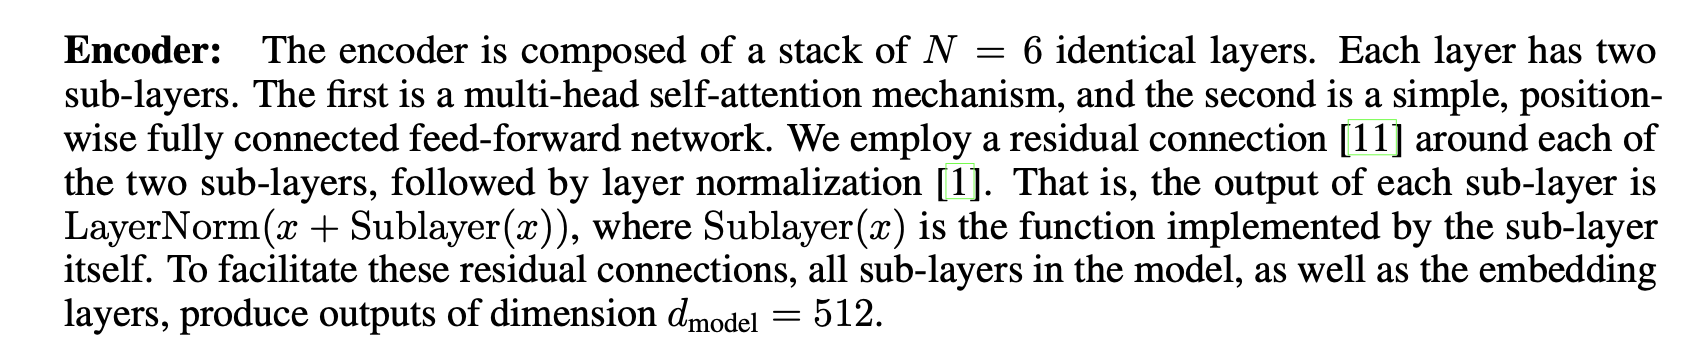

In [150]:
class ScaledDotProductAttention():
    def __init__(self):
        pass
    
    @staticmethod
    def attn(Q:tensor, K:tensor, V:tensor, mask=None) -> tensor:        
        if len(K.shape)==4: # handle for if it's a matrix instead of a vector
            scale = np.sqrt(K.shape[-1])
            attention_values = torch.matmul(Q, K.transpose(-2, -1))/scale
        else:  
            scale = np.sqrt(K.shape[0])
            attention_values = torch.matmul(Q, K.T)/scale
        
        if mask is not None:
            attention_values = attention_values.masked_fill(mask == 0, -1e9)
            
        softmax = F.softmax(attention_values, dim=-1)
        
        output = torch.matmul(softmax, V)
        
        # output shape: batch_size, num_heads, seq_length, head_dim)
        return output
    

In [358]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, model_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        assert model_dim % num_heads == 0, "Model must have a dimension divisible by # of heads."
        
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        
        # Need to learn Q, K, V weights
        self.wQ = nn.Linear(model_dim, model_dim)
        self.wK = nn.Linear(model_dim, model_dim)
        self.wV = nn.Linear(model_dim, model_dim)
        self.wOut = nn.Linear(model_dim, model_dim)
        
    @staticmethod
    def create_future_mask(size:int):
        # TIP: For sequential generation, have size be sequence length
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        return mask
        
    def forward(self, X, Q=None, mask=None, sequential_mask=False):
        # Q is option for decoder layer for cross-attention
        batch_size, seq_length, model_dim = x.size()
        
        Q, K, V = self.wQ(X) if Q is None else self.wQ(Q), self.wK(X), self.wV(X)
        # Need to reshape as (batch_size, num_heads, seq_length, head_dim)
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        
        if sequential_mask:
            mask = MultiHeadSelfAttention.create_future_mask(seq_length)
            
        attn = ScaledDotProductAttention.attn(Q, K, V, mask)
        comb_attn = attn.transpose(1, 2).contiguous()
        comb_attn = comb_attn.view(batch_size, seq_length, model_dim)
        
        # Final linear layer. Shape (batch_size, seq_length, model_dim)
        output = self.wOut(comb_attn)
        return output
        

**Excerpt:** "...each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between."

In [354]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, model_dim, ff_dim):
        # ff_dim == dimension of feed forward network (original value in paper is 2048)
        super(PositionwiseFeedForward, self).__init__()
        self.w1 = nn.Linear(model_dim, ff_dim)
        self.w2 = nn.Linear(ff_dim, model_dim)

    def forward(self, x):
        # max(0, xW1 + b1 )W2 + b2
        # |____  |_______| |______|
        #    ^      ^          ^
        #    |      |          | 
        #    |     NN 1 (w1)   |
        #  ReLu                |
        #                    NN 2 (w2)
        return self.w2( F.relu( self.w1(x) ) )

In [392]:
class PositionalEncodings(nn.Module):
    # Note: Needs to be a nn.Module to support the later dropout feature
    def __init__(self, X:tensor):
        super(PositionalEncodings, self).__init__()
        
        assert len(X.shape) == 3, "Excepting input to be 3 dimensions of (batch_size, seq_length, model_dim)"
        
        _, seq_length, model_dim = X.shape

        positional_encodings = torch.ones(seq_length*model_dim).float()
        
        positions = torch.arange(seq_length*model_dim)
        divisor = np.exp(np.log(10000) * positions * 2 / model_dim)
        sin = torch.sin(positions / divisor)
        cos = torch.cos(positions / divisor)
        
        positional_encodings[0::2] = sin[0::2]
        positional_encodings[1::2] = cos[1::2]
        
        positional_encodings = positional_encodings.view(seq_length, model_dim)
        self.positional_encodings = positional_encodings
    
    def forward(self, X):
        return X+self.positional_encodings

In [378]:
class EncoderBlock(nn.Module):
    def __init__(self, model_dim:int=512, num_heads:int=8, ff_dim:int=2048, dropout=0.1):
        """
        param: model_dim: the dimension of the attention mechanism (original paper is 512)
        param: num_heads: the number of attention layer heads to have (original paper is 8)
        param: ff_dim: the dimension of of the feed forward layer (original paper is 2048)
        param: dropout: the dropout rate for each of the layers (original paper is 0.1)
        """
        super(EncoderBlock, self).__init__()
        self.model_dim = model_dim
        
        self.attention_layer = MultiHeadSelfAttention(model_dim, num_heads)
        self.attention_layer_norm = nn.LayerNorm(model_dim)
        # Comperable to batch norm, that computes the mean and variance of a batch,
        # LayerNorm computes the mean and variance used for normalization from a single "body"
        # which in the above case is the mean and norm for the output attention layer matrix
        
        self.ffn = PositionwiseFeedForward(model_dim, ff_dim)
        self.ffn_norm = nn.LayerNorm(model_dim)
        
        # Original paper also applies a dropout to each sublayer of P(dropout) = 0.1
        self.dropout = nn.Dropout(dropout)
                
    def forward(self, X):
        # LayerNorm(X + SubLayer(X))
                
        X = self.attention_layer_norm(X + self.dropout(self.attention_layer(X)))
        
        X = self.ffn_norm(X + self.dropout(self.ffn(X)))
        
        return X

# SIMPLE! :)

In [367]:
batch_size = 8
seq_length = 30
num_heads = 8
model_dim = 512
ff_dim = 2048

x = torch.rand(batch_size*seq_length*model_dim)
x = shape_data(x, batch_size, seq_length, model_dim)
x = PositionalEncodings.encode(x)

encoder = EncoderBlock(model_dim, num_heads, ff_dim)
encoder.forward(x)

/var/folders/5r/tq98z9mx7ldcmk7cpdx25hvh0000gq/T/ipykernel_23370/2162885300.py:14: RuntimeWarning: overflow encountered in exp
  divisor = np.exp(np.log(10000) * positions * 2 / model_dim)


tensor([[[-7.0924e-01, -7.4078e-01, -1.6630e-03,  ..., -4.8503e-01,
           2.2389e-01,  1.1041e+00],
         [-1.4015e+00, -1.9820e-01, -1.5735e+00,  ..., -5.8804e-01,
           1.3679e-01, -7.6563e-01],
         [-5.6306e-01, -4.2254e-01, -6.0713e-01,  ..., -7.3337e-01,
          -2.2106e-01,  3.5372e-01],
         ...,
         [-1.7373e+00, -6.3289e-01, -1.0545e+00,  ...,  1.4097e+00,
           6.9401e-01, -2.7093e-01],
         [-6.4856e-01,  1.6307e-01, -1.4163e+00,  ..., -1.2400e+00,
           9.1593e-01, -5.9040e-01],
         [-1.1486e+00, -5.6965e-01, -2.8911e-01,  ..., -5.2770e-01,
           2.0226e-01, -4.4876e-01]],

        [[-6.8291e-01, -6.8648e-01, -1.7883e-01,  ..., -4.2178e-01,
           4.7708e-01, -5.6176e-02],
         [-1.0932e+00, -2.0365e-01, -7.8507e-01,  ..., -4.2911e-01,
           2.6017e-01,  1.4903e-01],
         [-4.1478e-01,  4.7307e-01, -1.3158e+00,  ..., -5.7277e-01,
          -4.7746e-01,  4.4166e-02],
         ...,
         [-6.0623e-01, -9

### Decoder:

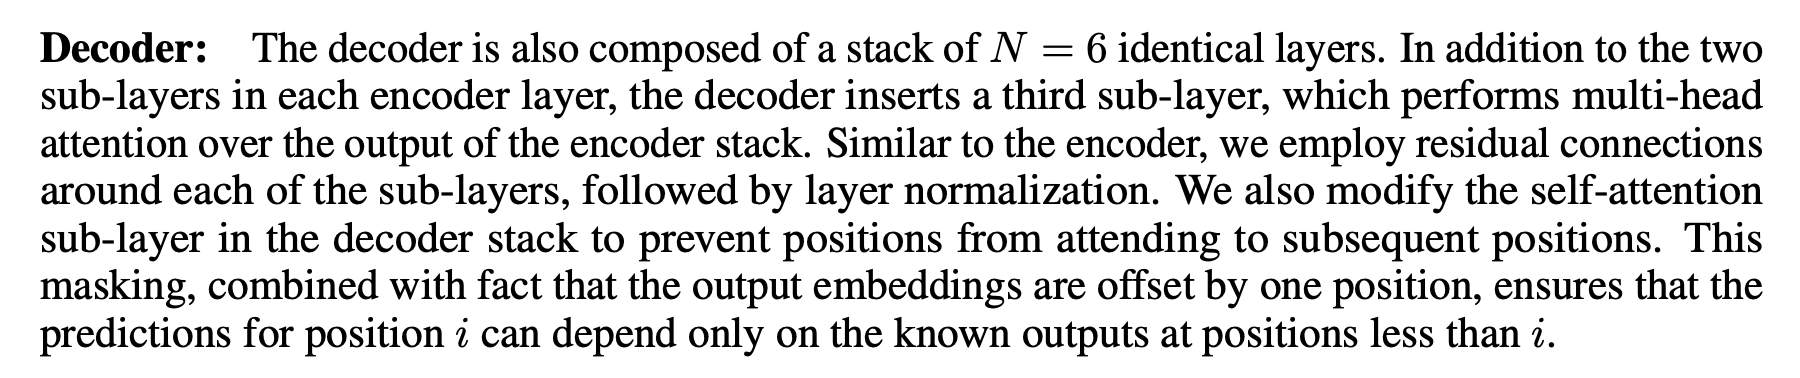

In [363]:
class DecoderBlock(nn.Module):
    def __init__(self, model_dim:int=512, num_heads:int=8, ff_dim:int=2048, dropout=0.1):
        """
        param: model_dim: the dimension of the attention mechanism (original paper is 512)
        param: num_heads: the number of attention layer heads to have (original paper is 8)
        param: ff_dim: the dimension of of the feed forward layer (original paper is 2048)
        param: dropout: the dropout rate for each of the layers (original paper is 0.1)
        """
        super(DecoderBlock, self).__init__()
        
        self.self_attention_layer = MultiHeadSelfAttention(model_dim, num_heads)
        self.self_attention_norm = nn.LayerNorm(model_dim)
        
        # add in a cross-attention layer to fold in the encoder outputs
        self.cross_attention_layer = MultiHeadSelfAttention(model_dim, num_heads)
        self.cross_attention_norm = nn.LayerNorm(model_dim)
        
        self.ffn = PositionwiseFeedForward(model_dim, ff_dim)
        self.ffn_norm = nn.LayerNorm(model_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X:tensor, encoder_output:tensor):
        
        self_attention = self.self_attention_layer(X, sequential_mask=True)
        self_attention = self.self_attention_norm(X + self.dropout(self_attention))
        
        # Excerpt:  "In 'encoder-decoder' attention layers, the queries come from the previous decoder layer,
        # and the memory keys and values come from the output of the encoder."
        cross_attention = self.cross_attention_layer(X=encoder_output, Q=self_attention)
        cross_attention = self.cross_attention_norm(self_attention + self.dropout(cross_attention))
        
        X = self.ffn_norm(cross_attention + self.dropout(self.ffn(cross_attention)))
        return X
        

### Transfomer: Putting it all Together

In [395]:
class DAS_TRANSFORMER(nn.Module):
    def __init__(self, num_encoders:int, num_decoders:int, vocab_size:int,
                 model_dim:int=512, num_heads:int=8, ff_dim:int=2048, dropout=0.1,
                ):
        super(DAS_TRANSFORMER, self).__init__()
        
        # A simple lookup table that stores embeddings of a fixed dictionary and size
        self.encoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)
        
        self.encoder = nn.ModuleList([EncoderBlock(model_dim, num_heads, ff_dim) for _ in range(num_encoders)])
        self.decoder = nn.ModuleList([DecoderBlock(model_dim, num_heads, ff_dim) for _ in range(num_decoders)])
        
        self.positional_encodings = PositionalEncodings(X)
        
        self.FFN = nn.Linear(model_dim, vocab_size) # outputs logits of what the next sequential word could be
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, encoder_inp, decoder_inp):
        # encoder_inp, decoder_inp are often called 'source' and 'target' respectively
        
        # Embed and apply psoitional encodes the inputs
        source = self.positional_encodings(self.encoder_embedding(encoder_inp))
        target = self.positional_encodings(self.decoder_embedding(decoder_inp))
        
        # Excerpt: "we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks"
        source = self.dropout(source)
        target = self.dropout(target)
        
        # Encode:
        encoding = source
        for encoder_block in self.encoder:
            encoding = encoder_block(encoding)
        
        # Decode:
        decoding = tgt_embedded
        for decoder_layer in self.decoder_layers:
            decoding = decoder_layer(decoding, encoding)
        
        output = self.FFN(decoding)
        return output

### Triaining
- In the original paper, the transformer was trained on "one machine with 8 NVIDIA P100 GPUs"
- Original dataset was the "WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs" and "WMT 2014 English-French dataset consisting of 36M sentences"
</br></br>
- I don't have this kind of compute so this will be scaled down

### Notes on Transformers:

#### What makes them so good?
- Transfomers, becaue of multi-head attention, it is able to parrallelize and thus much faster to train with a GPU, making them very efficient models


#### How does their performance compare to other models?
- Transfomers have the ability to preform better than other inter-datapoint models as long as you have a very large set of data
- For example, CNNs are able to learn a lot more with less data, but the marginal benefit of each subsequent data point decreases at a much faster rate than transformers, so over a very large dataset, transformers are able to have higher accuracy